In [37]:
import pandas as pd
import numpy as np

import re
import datetime as dt
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.tokenize import word_tokenize
import spacy
import re
import collections
import string
from wordcloud import WordCloud

from nltk.stem import PorterStemmer

In [5]:
df = pd.read_csv(os.path.join('raw_data', 'expedia_raw_reviews.csv'))

# Preprocessing

In [7]:
# Remove empty descriptions
df = df[df['description'].notnull()]
print('Number of reviews: %.f' % df.shape[0])

Number of reviews: 10105


#### Removing non-English comments

To base our sentiment analysis on comments written in English only, we filter out non-english comments by using the CLD2 librairy. CLD2 probabilistically detects over 80 languages in Unicode UTF-8 text, either plain text or HTML/XML.

Legacy encodings must be converted to valid UTF-8 by the caller. For mixed-language input, CLD2 returns the top three languages found and their approximate percentages of the total text bytes (e.g. 80% English and 20% French out of 1000 bytes of text means about 800 bytes of English and 200 bytes of French). Optionally, it also returns a vector of text spans with the language of each identified. This may be useful for applying different spelling-correction dictionaries or different machine translation requests to each span. The design target is web pages of at least 200 characters (about two sentences); CLD2 is not designed to do well on very short text, lists of proper names, part numbers, etc.

In [8]:
# sample code
import cld2
isReliable, textBytesFound, details = cld2.detect("This is my sample text")
print('  reliable: %s' % (isReliable != 0))
print('  textBytes: %s' % textBytesFound)
print('  details: %s' % str(details))

  reliable: True
  textBytes: 24
  details: (Detection(language_name='ENGLISH', language_code='en', percent=95, score=1736.0), Detection(language_name='Unknown', language_code='un', percent=0, score=0.0), Detection(language_name='Unknown', language_code='un', percent=0, score=0.0))


In [9]:
# test on a review
isReliable, textBytesFound, details = cld2.detect(df['description'][0])
print('  reliable: %s' % (isReliable != 0))
print('  textBytes: %s' % textBytesFound)
print('  details: %s' % str(details))

  reliable: True
  textBytes: 150
  details: (Detection(language_name='ENGLISH', language_code='en', percent=99, score=1436.0), Detection(language_name='Unknown', language_code='un', percent=0, score=0.0), Detection(language_name='Unknown', language_code='un', percent=0, score=0.0))


In [10]:
def get_language(review):
    result = cld2.detect(review)
    first_language = result[2][0][0]
    score_first_language = result[2][0][2]
    return first_language, score_first_language

In [11]:
sample_reviews = ['Teeny room but amazing rooftop bar. They don’t take cash for anything only credit cards for everything.',
 'Excelente o atendimento, a limpeza e o conforto.\r\nLocalização excelente.',
 'The bed was very comfortable.  The room (interior wall) was very quiet.\nRoom size was good.',
 'Loistava sijainti Time Squaren vieressä. Palvelualtis henkilökunta ja runsas aamiainen.',
 '交通の便がよく\n立地はひじょうによい。部屋もコンパクトでまずまず\n部屋数もそれなりにあるが、問題はエレベーターが２基と少なすぎで小さい。これではフロントから部屋まで時間がかる。\nあと２－３台は設置すべき。',
 "Hotel vieillot et cher, mais bien placé.\r\nService moyen. Nous avions demandé une chambre au 50ème étage par téléphone côté Downtown, mais très compliqué... fallait encore faire la demande chaque matin. Vitres sales. Hall sombre, fenêtre qui s'ouvre toute seule. Bruit ascenseur, climatisation...",
 'The hotel was disgusting, there was vomit outside my room that was there for around 4 days, the tap on the bath was lose, the plug socket was cracked and broken, the sink had a large crack in it, the sink plug didn’t work and wouldn’t hold the water, two draws were broken in the dresser unit. The hotel had 5 lift but only 2 were working. The wait for the remaining 2 lifts were around 45 minutes.',
 '상당히 불친절하고 방이 너무 좁아서 (아무리 부틱크 호텔이지만) 벽에다 옷걸이로 옷을 걸어야만 했다:옷장이 없다,호텔로비는 항상 붐비고 복잡하고 위치도 주변에 사무실뿐이라 \r\n그냥 그랬다.부틱호텔의 단점만 느끼고 돌아온 여행이였다\r\n프로트직원의 불친절함은 호텔에 직접 이메일을 보낼것이다.']

In [13]:
for review in sample_reviews:
    print('Sample review:', review[:20], '... > ', get_language(review))

Sample review: Teeny room but amazi ... >  ('ENGLISH', 99)
Sample review: Excelente o atendime ... >  ('PORTUGUESE', 98)
Sample review: The bed was very com ... >  ('ENGLISH', 98)
Sample review: Loistava sijainti Ti ... >  ('FINNISH', 98)
Sample review: 交通の便がよく
立地はひじょうによい。部 ... >  ('Japanese', 99)
Sample review: Hotel vieillot et ch ... >  ('FRENCH', 99)
Sample review: The hotel was disgus ... >  ('ENGLISH', 99)
Sample review: 상당히 불친절하고 방이 너무 좁아서  ... >  ('Korean', 99)


In [14]:
def label_english_nonenglish(review):
    first_language = get_language(review)
    if (first_language[0] == 'ENGLISH') & (first_language[1] > 80):
        return True
    else:
        return False

In [15]:
df.loc[:, 'is_english'] = df['description'].map(label_english_nonenglish)

In [16]:
print(f'The dataset contains {round(df.is_english.sum()/len(df), 3)} % of reviews written in English')

The dataset contains 0.83 % of reviews written in English


In [17]:
df_en = df[df['is_english']]
print('Number of reviews in English: %.f' % df_en.shape[0])

Number of reviews in English: 8388


In [22]:
df_en.to_csv(os.path.join('raw_data', 'expedia_eng_reviews.csv'), index=False)

# Corpus preprocessing

In [23]:
df_en = pd.read_csv(os.path.join('raw_data', 'expedia_eng_reviews.csv'))
corpus = list(df_en.loc[:, 'description'])
print('Corpus size: %.f' % len(corpus))

Corpus size: 8388


#### Expand English abbreviations
As the goal of this project is to perform sentiment analysis on hotel reviews, we want to expand English abbreviations such as don't to do not, and be able to keep stop words such as "not" in our corpus.

In [24]:
def decontracted(phrase):

    # punctuation mistake 
    phrase = re.sub(r"’", "'", phrase)
    
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


test = "Hey I'm Yann, how're you and how's it going ? That's interesting: I'd love to hear more about it. I'm not sure they'll like it. We won't know until tomorrow."
print(decontracted(test))

Hey I am Yann, how are you and how is it going ? That is interesting: I would love to hear more about it. I am not sure they will like it. We will not know until tomorrow.


In [25]:
sample_review = corpus[45]
print(decontracted(sample_review))

Do not stay here. Staff are extremely rude, they will not hold your luggage past four and they will not allow you to use the restroom downstairs. 


In [26]:
corpus = [decontracted(review) for review in corpus]

#### Tokenization and special character removal

The first step of preprocessing text data is to break every sentence into individual words, which is called tokenization. Taking individual words rather than sentences breaks down the connections between words. However, it is a common method used to analyze large sets of text data. It is efficient and convenient for computers to analyze the text data by examines what words appear in an article and how many times these words appear, and is sufficient to give insightful results.

In [28]:
words = word_tokenize(corpus[0])
print(words)

['The', 'overall', 'experience', 'was', 'great', '.', 'The', 'view', 'was', 'amazing', 'and', 'the', 'staff', 'was', 'friendly', '.', 'I', 'would', 'most', 'definitely', 'come', 'back', 'and', 'stay', 'at', 'the', 'Hilton', 'millennium']


In [29]:
for word in words[:10]:
    print('word:', word, end=' | ')
    
    # strip removes characters at the beginning and end of a string
    # string.punctuation contains: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    print('no punctuation:', word.strip(string.punctuation), end=' | ')
    
    # lower() and upper() change case
    print("lowercase:", word.lower(), end=' | ')

word: The | no punctuation: The | lowercase: the | word: overall | no punctuation: overall | lowercase: overall | word: experience | no punctuation: experience | lowercase: experience | word: was | no punctuation: was | lowercase: was | word: great | no punctuation: great | lowercase: great | word: . | no punctuation:  | lowercase: . | word: The | no punctuation: The | lowercase: the | word: view | no punctuation: view | lowercase: view | word: was | no punctuation: was | lowercase: was | word: amazing | no punctuation: amazing | lowercase: amazing | 

After tokenization, each news article will transform into a list of words, symbols, digits, and punctuation. You can specify whether you want to transform every word into a lowercase as well. The next step is to remove useless information. For example, symbols, digits, punctuations.

In [30]:
def process_tokenized_words(words):
    punctuation = string.punctuation
    customized_punctuation = ['“','”', '...', '', '’']
    for punct in customized_punctuation:
        punctuation += punct
    words = [word.lower().replace('\n', '') for word in words if word not in punctuation]
    
    # remove digits
    words = [word for word in words if len(re.findall(r'\d+', word)) == 0]
    
    return words

print(process_tokenized_words(words))

['the', 'overall', 'experience', 'was', 'great', 'the', 'view', 'was', 'amazing', 'and', 'the', 'staff', 'was', 'friendly', 'i', 'would', 'most', 'definitely', 'come', 'back', 'and', 'stay', 'at', 'the', 'hilton', 'millennium']


In [31]:
# tokenize words in each description of the corpus, lower case and remove punctuation
clean_corpus = [process_tokenized_words(word_tokenize(words)) for words in corpus]

#### Removing stop words

In [32]:
text = 'This movie is just not good enough'
nltk_stop_words = nltk.corpus.stopwords.words('english')
text_without_stop_words = [t for t in word_tokenize(text) if t not in nltk_stop_words]
display(f"nltk text without stop words: {text_without_stop_words}")

"nltk text without stop words: ['This', 'movie', 'good', 'enough']"

In [33]:
def remove_stop_words_tokens(words, keep_stop_words=[]):
    
    # define the corpus of stop words
    nltk_stop_words = nltk.corpus.stopwords.words('english')
    for stop_word in keep_stop_words:
        nltk_stop_words.remove(stop_word)
    
    # return list of tokenized words without stop words
    text_without_stop_words = [t for t in words if t not in nltk_stop_words]
    return text_without_stop_words

In [34]:
# keeping "not" 
print(remove_stop_words_tokens(word_tokenize(text), keep_stop_words=['not']))

['This', 'movie', 'not', 'good', 'enough']


In [35]:
clean_corpus_filtered = [remove_stop_words_tokens(words, keep_stop_words=['most', 'very', 'not']) for words in clean_corpus]

#### Stemming words

Stemming is a process of reducing words to their word stem, base or root form (for example, books — book, looked — look). The main two algorithms are Porter stemming algorithm (removes common morphological and inflexional endings from words) and Lancaster stemming algorithm (a more aggressive stemming algorithm). Below is an example of stemming using the Porter algorithm from NLTK librairy:

In [38]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
stemmer= PorterStemmer()
input_str='There are several types of stemming algorithms.'
input_str=word_tokenize(input_str)
for word in input_str:
    print(stemmer.stem(word))

there
are
sever
type
of
stem
algorithm
.


In [39]:
def stemm_tokenized_words(words):
    stemmer = PorterStemmer()
    stemmed_words = []
    for word in words:
        stemmed_words.append(stemmer.stem(word))
    return stemmed_words

In [40]:
print(stemm_tokenized_words(clean_corpus_filtered[10]))

['reserv', 'delux', 'king', 'room', 'citi', 'view', 'howev', 'not', 'understand', 'delux', 'part', 'refriger', 'insid', 'room', 'smaller', 'would', 'expect', 'overal', 'decent', 'clean', 'room']


In [41]:
clean_corpus_stemmed = [stemm_tokenized_words(words) for words in clean_corpus_filtered]

#### ... or lemmatizing!

Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma . 

If confronted with the token saw, stemming might return just s, whereas lemmatization would attempt to return either see or saw depending on whether the use of the token was as a verb or a noun. The two may also differ in that stemming most commonly collapses derivationally related words, whereas lemmatization commonly only collapses the different inflectional forms of a lemma. Linguistic processing for stemming or lemmatization is often done by an additional plug-in component to the indexing process, and a number of such components exist, both commercial and open-source.

#### Most frequent words

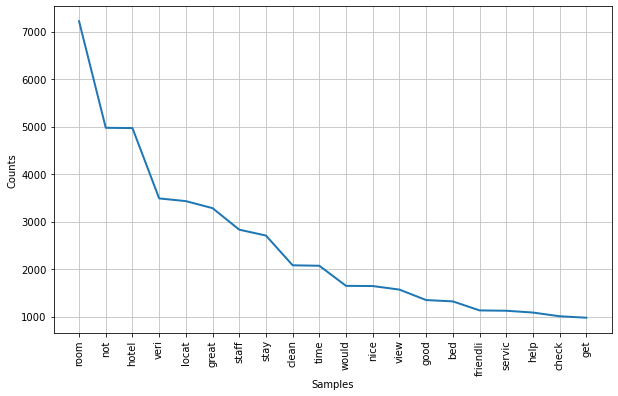

In [43]:
sample_reviews = []
for words in clean_corpus_stemmed:
    sample_reviews += words
    
# Get word frequencies
frequencies = nltk.probability.FreqDist(sample_reviews)

# Plot the frequencies
plt.figure(figsize=(10, 6))
frequencies.plot(20,cumulative=False)
plt.show()

# Preprocessing summary

In [44]:
class PreprocessText:
    
    def __init__(self, raw_text):
        self.text = raw_text
        
    # expand abbreviations
    def decontract_words(self):
        # punctuation mistake 
        phrase = re.sub(r"’", "'", self.text)
        phrase = re.sub(r'\\', "'", self.text)

        # specific
        phrase = re.sub(r"won\'t", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase
    
    def tokenize_words(self, decontract=True):
        if decontract:
            text = self.decontract_words()
        else:
            text = self.text
            
        tokenized_text = word_tokenize(text)
        return tokenized_text
    
    def preprocess_tokens(self, decontract=True):
        words = self.tokenize_words(decontract)
            
        # create list of punctuation characters
        punctuation = string.punctuation
        customized_punctuation = ['“','”', '...', '', '’']
        for punct in customized_punctuation:
            punctuation += punct
            
        # lower words and remove punctuation
        words = [word.lower().replace('\n', '') for word in words if word not in punctuation]
        words = [word for word in words if len(re.findall(r'\d+', word)) == 0]
        
        return words
    
    def remove_stop_words_tokens(self, keep_stop_words=['most', 'very', 'not'], decontract=True):
        words = self.preprocess_tokens(decontract)
        
        # define stop words
        nltk_stop_words = nltk.corpus.stopwords.words('english')
        for stop_word in keep_stop_words:
            nltk_stop_words.remove(stop_word)
            
        # return text without stop words
        text_without_stop_words = [t for t in words if t not in nltk_stop_words]
        
        return text_without_stop_words
    
    def stemm_tokenized_words(self, keep_stop_words=['most', 'very', 'not'], decontract=True):
        words = self.remove_stop_words_tokens(keep_stop_words, decontract)
        
        # initialize stemmers
        stemmer = PorterStemmer()
        stemmed_words = []
        for word in words:
            stemmed_words.append(stemmer.stem(word))
        
        return stemmed_words

In [46]:
preprocessed_corpus = [PreprocessText(raw_text) for raw_text in corpus]
preprocessed_corpus = [text_item.stemm_tokenized_words() for text_item in preprocessed_corpus]

In [47]:
print(preprocessed_corpus[10])

['reserv', 'delux', 'king', 'room', 'citi', 'view', 'howev', 'not', 'understand', 'delux', 'part', 'refriger', 'insid', 'room', 'smaller', 'would', 'expect', 'overal', 'decent', 'clean', 'room']
